# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import os
import json
from data_utils import get_train_samples
import ot
import torch
from einops import rearrange
from Utils.visualization_utils import visualize_barycenter_diracs
from Utils.joint_OT_mapping_linear_classreg import free_support_sinkhorn_barycenter
from warnings import catch_warnings

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data

In [4]:
data_path = '/Users/balazsmorvay/PycharmProjects/fmri_classifier/Data/Office-Caltech'

In [5]:
dataset = np.load(os.path.join(data_path, 'Objects_Decaf.npy'))
with open(os.path.join(data_path, 'Objects_crossval_index.json'), 'r') as f:
    fold_dict = json.loads(f.read())

domain_names = ['Webcam', 'Amazon', 'dslr', 'Caltech']

In [6]:
dataset.shape

(2533, 4098)

In [7]:
X = dataset[:, :-2]
X = (X - np.min(X, axis=0)) / (np.max(X, axis=0) - np.min(X, axis=0))
y = np.array(dataset[:, -2], dtype=int)
m = np.array(dataset[:, -1], dtype=int)
domains = np.unique(m).astype(int)
targets = domains

In [8]:
X.shape, y.shape, targets.shape

((2533, 4096), (2533,), (4,))

In [9]:
np.unique(y, return_counts=True)

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 array([284, 234, 237, 277, 222, 282, 297, 236, 216, 248]))

In [10]:
np.unique(m, return_counts=True)

(array([0, 1, 2, 3]), array([ 295,  958,  157, 1123]))

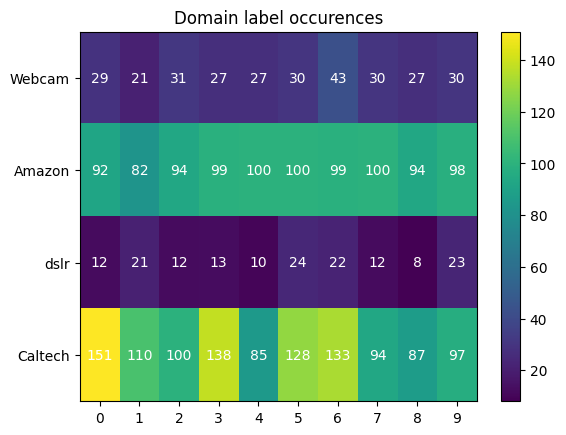

In [11]:
label_domain_occurence = np.zeros((4, 10), dtype=int)
for label in range(10):
    for i, domain in enumerate(domains):
        domain_indices = np.where(m == domain)
        domain_labels = y[domain_indices]
        label_indices = np.where(domain_labels == label+1)
        label_domain_occurence[i][label] = len(label_indices[0])

fig, ax = plt.subplots()
cax = ax.imshow(label_domain_occurence, cmap='viridis', aspect='auto')
for (i, j), val in np.ndenumerate(label_domain_occurence):
    ax.text(j, i, f'{val}', ha='center', va='center', color='white')
fig.colorbar(cax)
ax.set_xticks(np.arange(10))
ax.set_yticks(np.arange(4))
ax.set_xticklabels(str(i) for i in range(10))
ax.set_yticklabels(domain_names)
plt.title('Domain label occurences')
plt.show()

# Training

In [12]:
n_train = 60

In [13]:
X_train, y_train, X_test, y_test, m_test = get_train_samples(torch.tensor(X), torch.tensor(y), torch.tensor(m), n_train)
X_train.shape, y_train.shape, X_test.shape, y_test.shape, m_test.shape

(torch.Size([4, 60, 10, 4096]),
 torch.Size([4, 600]),
 torch.Size([2293, 4096]),
 torch.Size([2293]),
 torch.Size([2293]))

In [14]:
X_train = rearrange(X_train, 'm n l f -> m (n l) f')

In [15]:
X_train.shape

torch.Size([4, 600, 4096])

# Compute barycenter

In [16]:
n_bary = X_train.shape[0] * X_train.shape[1]

a_i = 1.0 / n_bary
w_i = torch.ones(size=(X_train.shape[1],), dtype=torch.int, device=device) * a_i

In [40]:
methods = ['sinkhorn',
           'sinkhorn_log',
           'greenkhorn',
           'sinkhorn_stabilized',
           'sinkhorn_epsilon_scaling']
method = methods[2]
print(f'Method: {method}')

Method: greenkhorn


In [ ]:
recompute = True

if not recompute and os.path.exists('barycenter.npy'):
    barycenter = np.load('barycenter.npy')
    print('Barycenter loaded')
else:
    with catch_warnings(record=True) as w:
        barycenter, log_dict = free_support_sinkhorn_barycenter(
            measures_locations=X_train,
            measures_weights=[w_i] * 4,
            X_init=torch.randn(
                (n_bary, X_train.shape[2]),
                dtype=torch.float32,
                device=device,
            ),
            reg=20.0,
            b=torch.ones((n_bary, ), dtype=torch.float32, device=device) * a_i,
            numItermax=1e5,
            numInnerItermax=int(2e15),
            verbose=True,
            stopThr=1e-7,
            log=True,
            method=method
        )
        # Save barycenter if kernel needs to be restarted
        np.save('barycenter.npy', barycenter)
        if w:
            print('Numerical error')

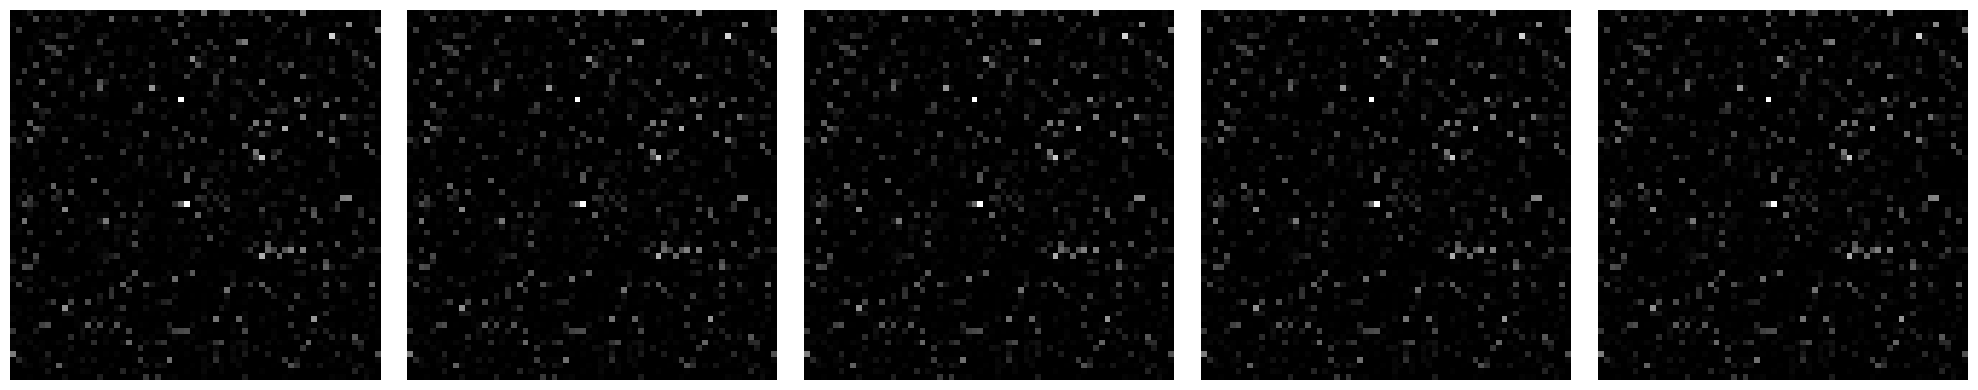

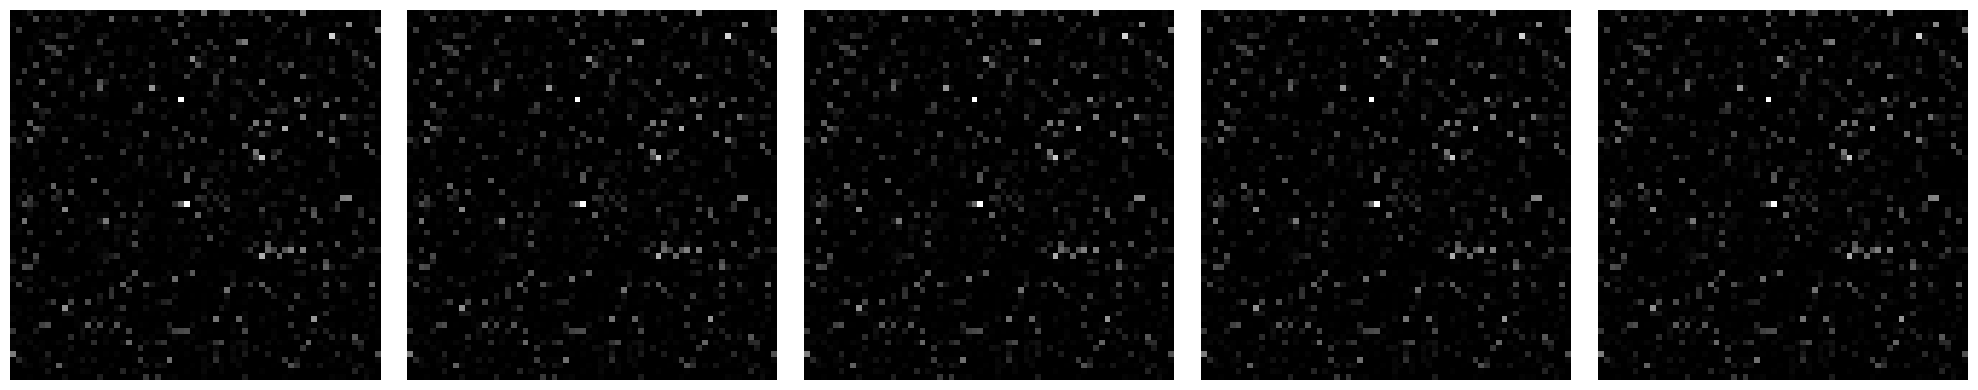

In [18]:
visualize_barycenter_diracs(barycenter, num_images=5)